In [ ]:
## Link to github repo with datasets and saved models: https://github.com/jb18529/DissertationDataset

In [3]:
#https://towardsdatascience.com/hidden-markov-model-implemented-from-scratch-72865bda430e
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pandas as pd
from itertools import product
from functools import reduce

2023-09-07 07:10:24.744677: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 07:10:25.211895: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 07:10:27.281826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
class ProbabilityVector:
    def __init__(self, probabilities: dict):
        states = probabilities.keys()
        probs = probabilities.values()

        # assert is debugging error - AssertionError
        assert len(states) == len(probs), "The probabilities must match the states."
        assert len(states) == len(set(states)), "The states must be unique."
        assert abs(sum(probs) - 1.0) < 1e-12, "Probabilities must sum up to 1."
        #puts in list all probabilties between 0 and 1 and compares to length of probs
        #print(len(probs))
        assert len(list(filter(lambda x: 0 <= x <= 1, probs))) == len(probs), \
        "Probabilities must be numbers from [0, 1] interval."

        # self.states will be sorted list of keys of input dictionary
        self.states = sorted(probabilities)
        # syntax for map is
        # map(function, iterable) the iterable will pass through the function and the output will be put into a list
        # lambda x: probabilities[x] will pass basically take input and use it to index probabilities array
        # array of dimension of 1 row and as many columns as needed or [x,y, z, a, ...]
        self.values = np.array(list(map(lambda x: probabilities[x], self.states))).reshape(1, -1)

    @classmethod
    def initialize(cls, states: list):
        size = len(states)
        rand = np.random.rand(size) / (size**2) + 1 / size
        rand /= rand.sum(axis=0)
        return cls(dict(zip(states, rand)))
    
    #bug, was it states or state?
    @classmethod
    def from_numpy(cls, array: np.ndarray, states: list):
        return cls(dict(zip(states, list(array))))
    
    @property
    def dict(self):
        #zip return a list of tuples with pair elements in each tuple
        # .flatten() reduces the dimension of an array so instead of nested arrays of
        # 2D you get a 1D array so list of list to list
        return {k:v for k, v in zip(self.states, list(self.values.flatten()))}
    
    @property
    def df(self):
        return pd.DataFrame(self.values, columns=self.states, index=['probability'])
    
    def __repr__(self):
        return "P({}) = {}.".format(self.states, self.values)
    
    def __eq__(self, other):
        if not isinstance(other, ProbabilityVector):
            raise NotImplementedError
        if (self.states == other.states) and (self.values == other.values).all():
            return True
        return False
    # : str mean input is type string and -> means output is type float
    def __getitem__(self, state: str) -> float:
        if state not in self.states:
            raise ValueError("Requesting unknown probability state from vector.")
        index = self.states.index(state)
        return float(self.values[0, index])

    def __mul__(self, other) -> np.ndarray:
        if isinstance(other, ProbabilityVector):
            return self.values * other.values
        # when multiplying probability vector (PV) with scalar the return structure is a numpy array not another PV
        elif isinstance(other, (int, float)):
            return self.values * other
        else:
            NotImplementedError
        
    def __rmul__(self, other) -> np.ndarray:
        return self.__mul__(other)
    
    def __matmul__(self, other) -> np.ndarray:
        if isinstance(other, ProbabilityMatrix):
            # @ in middle of line is matrix multiplication
            return self.values @ other.values
        
    def __truediv__(self, number) -> np.ndarray:
        if not isinstance(number, (int, float)):
            raise NotImplementedError
        x = self.values
        # you can make if else statements on one line with return
        return x / number if number != 0 else x / (number + 1e-12)
    
    def argmax(self):
        index = self.values.argmax()
        return self.states[index]

In [12]:
class ProbabilityMatrix:
    def __init__(self, prob_vec_dict: dict):
        assert len(prob_vec_dict) > 1, \
            "The number of input probability vector must be greater than one."
        assert len(set([str(x.states) for x in prob_vec_dict.values()])) == 1, \
            "The internal states of all the vectors must be identical."
        assert len(prob_vec_dict.keys()) == len(set(prob_vec_dict.keys())), \
            "All observables must be unique."
        
        #sorted(dictionary) returns a list of the sorted keys in numerical or alphabetical ascending order
        self.states = sorted(prob_vec_dict)
        # takes first element of self.states from sorted keys and access the value
        self.observables = prob_vec_dict[self.states[0]].states
        self.values = np.stack([prob_vec_dict[x].values for x in self.states]).squeeze()

    @classmethod
    def initialize(cls, states: list, observables: list):
        size = len(states)
        rand = np.random.rand(size, len(observables)) / (size ** 2) + 1 / size
        rand /= rand.sum(axis=1).reshape(-1, 1)
        aggr = [dict(zip(observables, rand[i, :])) for i in range(len(states))]
        pvec = [ProbabilityVector(x) for x in aggr]
        return cls(dict(zip(states, pvec)))
    
    @classmethod
    def from_numpy(cls, array:
                    np.ndarray,
                    states: list,
                    observables: list):
        p_vecs = [ProbabilityVector(dict(zip(observables, x))) \
                    for x in array]
        
        return cls(dict(zip(states, p_vecs)))

    @property
    def dict(self):
        return self.df.to_dict()
    
    @property
    def df(self):
        return pd.DataFrame(self.values, columns=self.observables, index=self.states)
    
    def __repr__(self):
        return "PM {} states: {} -> obs: {}.".format(self.values.shape, self.states, self.observables)
    
    #invoked when indexing object i.e probabilitymatrix['1H']
    def __getitem__(self, observable: str) -> np.ndarray:
        if observable not in self.observables:
            raise ValueError("Requesting unknown probability observable from the matrix.")
        index = self.observables.index(observable)
        return self.values[:, index].reshape(-1, 1)

In [13]:
class HiddenMarkovChain:
    def __init__(self, T, E, pi):
        self.T = T # state transition matrix A
        self.E = E # emission matrix B
        self.pi = pi # initial state probability distribution
        self.states = pi.states
        self.observables = E.observables

    def __repr__(self):
        return "HML states: {} -> observables: {}.".format\
            (len(self.states), len(self.observables))
    
    @classmethod
    def initialize(cls, states: list, observables: list):
        T = ProbabilityMatrix.initialize(states, states)
        E = ProbabilityMatrix.initialize(states, observables)
        pi = ProbabilityVector.initialize(states)
        return cls(T, E, pi)
    
    def _create_all_chains(self, chain_length):
        return list(product(*(self.states,) * chain_length))
    
    def score(self, observations: list) -> float:
        def mul(x, y): return x * y
    
        score = 0
        all_chains = self._create_all_chains(len(observations))
        for idx, chain in enumerate(all_chains):
            expanded_chain = list(zip(chain, [self.T.states[0]] + list(chain)))
            expanded_obser = list(zip(observations, chain))
            p_observations = list(map(lambda x: self.E.df.loc[x[1], x[0]], expanded_obser))
            p_hidden_state = list(map(lambda x: self.T.df.loc[x[1], x[0]], expanded_chain))

            p_hidden_state[0] = self.pi[chain[0]]
            score += reduce(mul, p_observations) * reduce(mul, p_hidden_state)
        return score

In [14]:
# Score with forward pass

class HiddenMarkovChain_FP(HiddenMarkovChain):
    def _alphas(self, observations: list) -> np.ndarray:
        alphas = np.zeros((len(observations), len(self.states)))
        alphas[0, :] = self.pi.values * self.E[observations[0]].T
        for t in range(1, len(observations)):
            alphas[t, :] = (alphas[t - 1, :].reshape(1, -1) @ self.T.values) \
            * self.E[observations[t]].T
        return alphas
    
    def score(self, observations: list) -> float:
        alphas = self._alphas(observations)
        return float(alphas[-1].sum())

In [16]:
# use A, B, pi to generate a sequence of random observables
# starting from initial state probability pi
# Simulation and Convergence
class HiddenMarkovChain_Simulation(HiddenMarkovChain):
    def run(self, length: int) -> tuple[list, list]:
        assert length >= 0, "The chain needs to be a non-negative number."
        s_history = [0] * (length + 1)
        o_history = [0] * (length + 1)

        prb = self.pi.values
        obs = prb @ self.E.values
        s_history[0] = np.random.choice(self.states, p=prb.flatten())
        o_history[0] = np.random.choice(self.observables, p=obs.flatten())

        for t in range(1, length + 1):
            prb = prb @ self.T.values
            obs = prb @self.E.values
            s_history[t] = np.random.choice(self.states, p=prb.flatten())
            o_history[t] = np.random.choice(self.observables, p=obs.flatten())

        return o_history, s_history

class HiddenMarkovChain_Uncover(HiddenMarkovChain_Simulation):
    def _alphas(self, observations: list) -> np.ndarray:
        alphas = np.zeros((len(observations), len(self.states)))
        alphas[0, :] = self.pi.values * self.E[observations[0]].T
        for t in range(1, len(observations)):
            alphas[t, :] = (alphas[t -1,:].reshape(1, -1) @ self.T.values) \
                * self.E[observations[t]].T
        return alphas
    
    def _betas(self, observations: list) -> np.ndarray:
        betas = np.zeros((len(observations), len(self.states)))
        betas[-1, :] = 1
        for t in range(len(observations) - 2, -1, -1):
            betas[t, :] = (self.T.values @ (self.E[observations[t + 1]] \
                        * betas[t+1, :].reshape(-1, 1))).reshape(1, -1)
        return betas
    
    def uncover(self, observations: list) -> list:
        alphas = self._alphas(observations)
        betas = self._betas(observations)
        maxargs = (alphas * betas).argmax(axis=1)
        return list(map(lambda x: self.states[x], maxargs))
    
# Training the model
# must determin a, b and pi
class HiddenMarkovLayer(HiddenMarkovChain_Uncover):
    def _digammas(self, observations: list) -> np.ndarray:
        L, N = len(observations), len(self.states)
        digammas = np.zeros((L - 1, N, N))

        alphas = self._alphas(observations)
        betas = self._betas(observations)
        score = self.score(observations)
        
        for t in range(L -1):
            P1 = (alphas[t, :].reshape(-1, 1) * self.T.values)
            P2  = self.E[observations[t + 1]].T * betas[t + 1].reshape(1, -1)
            digammas[t, :, :] = P1 * P2 / score

        return digammas

In [17]:
class HiddenMarkovModel:
    def __init__(self, hml: HiddenMarkovLayer):
        self.layer = hml
        self._score_init = 0
        self.score_history = []

    @classmethod
    def initialize(cls, states: list, observables: list):
        layer = HiddenMarkovLayer.initialize(states, observables)
        return cls(layer)
    
    def update(self, observations: list) -> float:
        alpha = self.layer._alphas(observations)
        beta = self.layer._betas(observations)
        digamma = self.layer._digammas(observations)
        score = alpha[-1].sum()
        gamma = alpha * beta / score

        L = len(alpha)
        obs_idx = [self.layer.observables.index(x) \
                   for x in observations]
        capture = np.zeros((L, len(self.layer.states), len(self.layer.observables)))

        for t in range(L):
            capture[t, :, obs_idx[t]] = 1.0

        pi = gamma[0]
        T = digamma.sum(axis=0) / gamma[:-1].sum(axis=0).reshape(-1, 1)
        E = (capture * gamma[:, :, np.newaxis]).sum(axis=0) / gamma.sum(axis=0).reshape(-1, 1)

        self.layer.pi = ProbabilityVector.from_numpy(pi, self.layer.states)
        self.layer.T = ProbabilityMatrix.from_numpy(T, self.layer.states, self.layer.states)
        self.layer.E = ProbabilityMatrix.from_numpy(E, self.layer.states, self.layer.observables)

        return score
    def train(self, observations: list, epochs: int, tol=None):
        self._score_init = 0
        self.score_history = (epochs + 1) * [0]
        # if tol is one of the type int or float returns true
        early_stopping = isinstance(tol, (int, float))

        for epoch in range(1, epochs + 1):
            score = self.update(observations)
            #score = round(score, 2)
            print("Training... epoch = {} out of {}, score = {}.".format(epoch, epochs, score))
            if early_stopping and abs(self._score_init - score) / score < tol:
                print("Early stopping.")
                break
            self._score_init = score
            self.score_history[epoch] = score
            

In [31]:
# Initial State Probability Distribution calculator: https://www.statskingdom.com/markov-chain-calculator.html


#a1 = ProbabilityVector({'AA1': 0.20, 'AA2': 0.80, 'AA3': 0.00, 'AA4': 0.00})
#a2 = ProbabilityVector({'AA1': 0.30, 'AA2': 0.10, 'AA3': 0.60, 'AA4': 0.00})
#a4 = ProbabilityVector({'AA1': 0.00, 'AA2': 0.00, 'AA3': 0.60, 'AA4': 0.40})

# State Transition Matrix
a1 = ProbabilityVector({'AA1': 0.20, 'AA2': 0.80, 'AA3': 0.00, 'AA4': 0.00})
a2 = ProbabilityVector({'AA1': 0.45, 'AA2': 0.10, 'AA3': 0.45, 'AA4': 0.00})
a3 = ProbabilityVector({'AA1': 0.00, 'AA2': 0.45, 'AA3': 0.10, 'AA4': 0.45})
a4 = ProbabilityVector({'AA1': 0.00, 'AA2': 0.00, 'AA3': 0.80, 'AA4': 0.20})


# Emission Probability Matrix (EM)

## Confusion Matrix EM
# change 0 to 0.01
# b1 = ProbabilityVector({'AA1': 0.52, 'AA2': 0.16, 'AA3': 0.16, 'AA4': 0.16})
# b2 = ProbabilityVector({'AA1': 0.16, 'AA2': 0.52, 'AA3': 0.16, 'AA4': 0.16})
# b3 = ProbabilityVector({'AA1': 0.01, 'AA2': 0.65, 'AA3': 0.01, 'AA4': 0.33})
# b4 = ProbabilityVector({'AA1': 0.33, 'AA2': 0.01, 'AA3': 0.01, 'AA4': 0.65})

## Hand coded EM
b1 = ProbabilityVector({'AA1': 0.52, 'AA2': 0.16, 'AA3': 0.16, 'AA4': 0.16})
b2 = ProbabilityVector({'AA1': 0.16, 'AA2': 0.52, 'AA3': 0.16, 'AA4': 0.16})
b3 = ProbabilityVector({'AA1': 0.16, 'AA2': 0.16, 'AA3': 0.52, 'AA4': 0.16})
b4 = ProbabilityVector({'AA1': 0.16, 'AA2': 0.16, 'AA3': 0.16, 'AA4': 0.52})


A = ProbabilityMatrix({'AA1': a1, 'AA2': a2, 'AA3': a3, 'AA4': a4})
B = ProbabilityMatrix({'AA1': b1, 'AA2': b2, 'AA3': b3, 'AA4': b4})
# pi is based on A (state transition matrix of hidden states)

# Calculate use initial state probability distribution calculation
#pi = ProbabilityVector({'AA1': 0.17, 'AA2': 0.33, 'AA3': 0.33, 'AA4': 0.17})

# Hand coded initial state probability distribution calculation
pi = ProbabilityVector({'AA1': 0.25, 'AA2': 0.25, 'AA3': 0.25, 'AA4': 0.25})

# 0.3321, 0.1679
hmc = HiddenMarkovChain(A, B, pi)
observations = ['AA1', 'AA2', 'AA3', 'AA4']

print("Score for hmc {} is {:f}.".format(observations, hmc.score(observations)))

# all_possible_observations = {'AA1', 'AA2', 'AA3', 'AA4'}
# chain_length = 4  # any int > 0
# all_observation_chains = list(product(*(all_possible_observations,) * chain_length))
# all_possible_scores = list(map(lambda obs: hmc.score(obs), all_observation_chains))
#print("All possible scores added: {}.".format(sum(all_possible_scores)))

hmc_fp = HiddenMarkovChain_FP(A, B, pi)

#observations = ['1S', '2M', '3L', '2M', '1S']
print("Score for hmc_fp {} is {:f}.".format(observations, hmc_fp.score(observations)))

all_possible_observations = {'AA1', 'AA2', 'AA3', 'AA4'}
chain_length = 4  # any int > 0
all_observation_chains = list(product(*(all_possible_observations,) * chain_length))
all_possible_scores = list(map(lambda obs: hmc_fp.score(obs), all_observation_chains))
print("All possible scores added: {}.".format(sum(all_possible_scores)))


Score for hmc ['AA1', 'AA2', 'AA3', 'AA4'] is 0.007016.
Score for hmc_fp ['AA1', 'AA2', 'AA3', 'AA4'] is 0.007016.
All possible scores added: 0.9999999999999996.


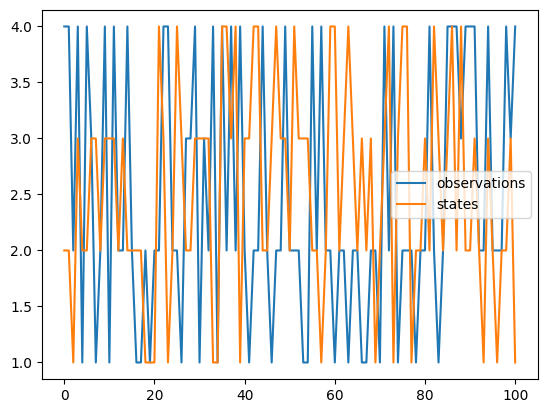

In [166]:
hmc_s = HiddenMarkovChain_Simulation(A, B, pi)
observation_hist, states_hist = hmc_s.run(100)  # length = 100
stats = pd.DataFrame({
    'observations': observation_hist,
    'states': states_hist}).applymap(lambda x: int((x[2])) ).plot()

In [ ]:
hmc_s = HiddenMarkovChain_Simulation(A, B, pi)

stats = {}
for length in np.logspace(1, 5, 40).astype(int):
    observation_hist, states_hist = hmc_s.run(length)
    stats[length] = pd.DataFrame({
        'observations': observation_hist,
        'states': states_hist}).applymap(lambda x: int(x[2]))

S = np.array(list(map(lambda x: 
        x['states'].value_counts().to_numpy() / len(x), stats.values())))

plt.semilogx(np.logspace(1, 5, 40).astype(int), S)
plt.xlabel('Chain length T')
plt.ylabel('Probability')
plt.title('Converging probabilities.')
plt.legend(['AA1', 'AA2'])
plt.show()

In [34]:
hmc3 = HiddenMarkovChain_Uncover(A, B, pi)
# Latent is hidden state sequence
# observed_sequence, latent_sequence = hmc.run(3)
# print(observed_sequence)
# print(latent_sequence)
#uncovered_sequence = hmc.uncover(['AA1', 'AA2', 'AA3', 'AA4', 'AA3', 'AA4'])



## Short test sequences

#observed_sequence = ['AA1', 'AA2', 'AA3', 'AA4']
observed_sequence = ['AA1', 'AA2', 'AA2', 'AA4']
latent_sequence = ['AA1', 'AA2', 'AA3', 'AA4']


#observed_sequence1 = ['AA1', 'AA2', 'AA3', 'AA4', 'AA4', 'AA3', 'AA2', 'AA3']
#observed_sequence2 = ['AA1', 'AA2', 'AA2', 'AA4', 'AA1', 'AA4', 'AA2', 'AA1']
#latent_sequence1 = ['AA1', 'AA2', 'AA3', 'AA4', 'AA4', 'AA3', 'AA2', 'AA3']
#latent_sequence2 = ['AA1', 'AA2', 'AA3', 'AA4', 'AA4', 'AA3', 'AA2', 'AA1']

uncovered_sequence = hmc3.uncover(observed_sequence)

print("Observed Sequence ", observed_sequence, "\nLatent Sequence   ", latent_sequence, "\nUncovered Sequence", uncovered_sequence)

Observed Sequence  ['AA1', 'AA2', 'AA2', 'AA4'] 
Latent Sequence    ['AA1', 'AA2', 'AA3', 'AA4'] 
Uncovered Sequence ['AA1', 'AA2', 'AA3', 'AA4']


In [61]:
all_possible_states = {'AA1', 'AA2', 'AA3', 'AA4'}
chain_length = 8
all_states_chains = list(product(*(all_possible_states,) * chain_length))

df = pd.DataFrame(all_states_chains)
dfp = pd.DataFrame()

for i in range(chain_length):
    dfp['p' + str(i)] = df.apply(lambda x: hmc.E.df.loc[x[i], observed_sequence2[i]], axis=1)

scores = dfp.sum(axis=1).sort_values(ascending=False)
df = df.iloc[scores.index]
df['score'] = scores
df.head(20).reset_index()

,index,0,1,2,3,4,5,6,7,score
0,48270,AA1,AA2,AA2,AA4,AA1,AA4,AA2,AA1,4.16
1,48269,AA1,AA2,AA2,AA4,AA1,AA4,AA2,AA3,3.80
2,48258,AA1,AA2,AA2,AA4,AA1,AA4,AA4,AA1,3.80
3,48262,AA1,AA2,AA2,AA4,AA1,AA4,AA3,AA1,3.80
4,40078,AA1,AA3,AA2,AA4,AA1,AA4,AA2,AA1,3.80
5,48266,AA1,AA2,AA2,AA4,AA1,AA4,AA1,AA1,3.80
6,15502,AA4,AA2,AA2,AA4,AA1,AA4,AA2,AA1,3.80
7,48268,AA1,AA2,AA2,AA4,AA1,AA4,AA2,AA4,3.80
8,44174,AA1,AA1,AA2,AA4,AA1,AA4,AA2,AA1,3.80
9,45198,AA1,AA2,AA4,AA4,AA1,AA4,AA2,AA1,3.80


In [106]:
# Train model find lambda = (A, B,pi) given a desired observation sequence
# O, our model lambda would give best fit

np.random.seed(42)

observations = ['AA1', 'AA2', 'AA2', 'AA4']

states = ['AA1', 'AA2', 'AA3', 'AA4']
observables = ['AA1', 'AA2', 'AA3', 'AA4']

hml = HiddenMarkovLayer.initialize(states, observables)
hmm = HiddenMarkovModel(hml)

hmm.train(observations, 19)

Training... epoch = 1 out of 19, score = 0.0038844347613502172.
Training... epoch = 2 out of 19, score = 0.015793340963577512.
Training... epoch = 3 out of 19, score = 0.01625435159221003.
Training... epoch = 4 out of 19, score = 0.01778995145579515.
Training... epoch = 5 out of 19, score = 0.02187055165363147.
Training... epoch = 6 out of 19, score = 0.029795277188381868.
Training... epoch = 7 out of 19, score = 0.0460139567013228.
Training... epoch = 8 out of 19, score = 0.08021846361062371.
Training... epoch = 9 out of 19, score = 0.11760775918295965.
Training... epoch = 10 out of 19, score = 0.13491982302613115.
Training... epoch = 11 out of 19, score = 0.14284593805988494.
Training... epoch = 12 out of 19, score = 0.14833628030092377.
Training... epoch = 13 out of 19, score = 0.15298251777359442.
Training... epoch = 14 out of 19, score = 0.15935323335719306.
Training... epoch = 15 out of 19, score = 0.17218621766982223.
Training... epoch = 16 out of 19, score = 0.19652287295678023

In [135]:
observed_sequence1 = ['AA1', 'AA2', 'AA2', 'AA4']
uncovered_sequence1 = hmc.uncover(observed_sequence1)
print(uncovered_sequence1)

['AA1', 'AA2', 'AA3', 'AA4']


In [132]:
RUNS = 100000
T = 3

chains = RUNS * [0]
for i in range(len(chains)):
    chain = hmm.layer.run(T)[0]
    chains[i] = '-'.join(chain)
    print(chains[i])

AA1-AA2-AA2-AA2
AA1-AA2-AA2-AA2
AA1-AA2-AA2-AA2
AA1-AA2-AA4-AA4
AA1-AA2-AA2-AA2
AA1-AA2-AA2-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA2-AA2
AA1-AA2-AA2-AA2
AA1-AA4-AA4-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA2-AA2
AA1-AA2-AA2-AA4
AA1-AA2-AA2-AA2
AA1-AA2-AA2-AA4
AA1-AA2-AA4-AA2
AA1-AA2-AA4-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA2-AA2
AA1-AA2-AA4-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA4-AA2
AA1-AA2-AA2-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA2-AA2
AA1-AA2-AA2-AA4
AA1-AA2-AA2-AA4
AA1-AA2-AA4-AA2
AA1-AA2-AA4-AA2
AA1-AA2-AA2-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA4-AA4
AA1-AA2-AA4-AA2
AA1-AA2-AA4-AA2
AA1-AA2-AA2-AA4
AA1-AA2-AA2-AA2
AA1-AA2-AA2-AA4
AA1-AA2-AA2-AA2
AA1-AA2-AA2-AA2
AA1-AA2-AA2-AA4
AA1-AA2-

In [130]:
# df = pd.DataFrame(pd.Series(chains).value_counts(), columns=['counts']).reset_index().rename(columns={'index': 'chain'})
# df = pd.merge(df, df['chain'].astype(str).str.split('-', expand=True), left_index=True, right_index=True)

# s = []
# for i in range(T + 1):
#     s.append(df.apply(lambda x: x[i] == observations[i], axis=1))

# df['matched'] = pd.concat(s, axis=1).sum(axis=1)
# df['counts'] = df['counts'] / RUNS * 100
# df = df.drop(columns=['chain'])
# df.head(30)

,counts,matched
